In [9]:
from igraph import Graph
import numpy as np
import pandas as pd
import igraph
import networkx as nx

In [2]:
nodes=pd.read_csv('Nodes_df4.csv')
edges=pd.read_csv('Edges_df4.csv')

#### Individuiamo il Giant Component

In [3]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [4]:
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [26]:
#codice per identificare giant component
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [27]:
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

C:\ProgramData\Anaconda3\lib\site-packages\igraph\__init__.py:1281: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  membership, _, q = GraphBase.community_leading_eigenvector(


'Clustering with 3527 elements and 2 clusters'

In [28]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

In [29]:
df_eigen

,nodes,clusters
0,2279301,0
1,5253961,0
2,5718002,1
3,6012422,0
4,6243422,0
...,...,...
3522,1474895624843800581,0
3523,1475049574809186307,0
3524,1475122883164876805,0
3525,1475496660268638210,0


<AxesSubplot:>

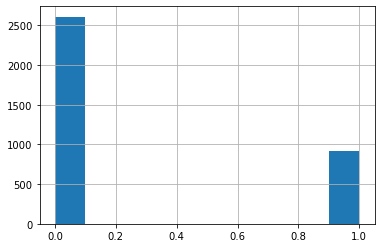

In [30]:
df_eigen["clusters"].hist()

In [31]:
df_eigen.groupby("clusters")["clusters"].count()

clusters
0    2608
1     919
Name: clusters, dtype: int64

In [32]:
def color_clusters(cluster_df,cluster_field,new_cluster_field_name):
    clusters=list(set(cluster_df[cluster_field]))
    nodes[new_cluster_field_name]=0

    for index, row in cluster_df.iterrows():
        subset=nodes[nodes.Id==int(row['nodes'])]
        if subset.empty == False:
            sub_index=subset.index
            for cluster in clusters:
                if row['clusters']==cluster:
                    nodes.at[sub_index,new_cluster_field_name]=cluster+1
        else:
            continue

In [34]:
color_clusters(df_eigen,'clusters','cluster_eigen')

In [8]:
#clusters=list(set(df_eigen.clusters))
#nodes['Cluster_eigen']=0
#
#colour=[]
#for index, row in df_eigen.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        for cluster in clusters:
#            if row['clusters']==cluster:
#                nodes.at[sub_index,'Cluster_eigen']=cluster+1
#    else:
#        continue

In [33]:
#utile solo nel caso che il dataframe di partenza presenti gli hex colors invece dei cluster

#for i,r in dummy.iterrows():
#    if r['Colour']=='#aaaacc':
#        dummy.at[i,'Colour']=0
#    if r['Colour']=='#007474':
#        dummy.at[i,'Colour']=1
#    if r['Colour']=='#fb1239':
#        dummy.at[i,'Colour']=2

#### Creazione indice e applicazione k-means

In [36]:
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [37]:
def Jaccard(nodesA,nodesB):
    intersect = [value for value in nodesA if value in nodesB]
    union=list(set(nodesA+nodesB))
    compute_jaccard=len(intersect)/len(union)
    return compute_jaccard

In [38]:
distance_matrix_j=[[ Jaccard(values_col,values_row) for values_row in contiguous_nodes_dict.values()] for values_col in contiguous_nodes_dict.values()]

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000,algorithm="elkan").fit(distance_matrix_j)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

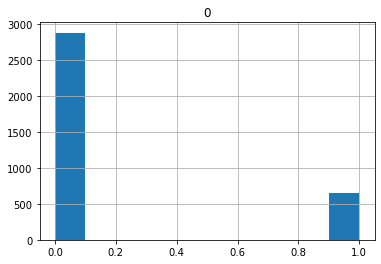

In [40]:
pd.DataFrame(kmeans.labels_).hist()

In [41]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans.labels_})

In [46]:
color_clusters(df_means,'clusters','cluster_kmeans')

In [47]:
nodes.to_csv("nodes_provvisorio.csv")

In [378]:
#nodes['Colour']='#aaaacc'
#
#colour=[]
#for index, row in df_means.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        if row['clusters']==0:
#            nodes.at[sub_index,'Colour']='1'
#        if row['clusters']==1:
#            nodes.at[sub_index,'Colour']='2'
#    else:
#        continue

#### Modularity maximization

In [130]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [131]:
new_G=new_G.to_undirected()

In [132]:
from networkx.algorithms.community import modularity_max
c = list(modularity_max.greedy_modularity_communities(new_G))

In [456]:
nodes['Cluster_mod']='#aaaacc'

colours_list=list(range(0,24))
i=0
for community in c:
    colour=[]
    for node in list(community):
        subset=nodes[nodes.Id==int(node)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Cluster_mod']=colours_list[i]
        else:
            continue
    i+=1

#### Girvan-Newman

In [414]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [415]:
new_G=new_G.to_undirected()

In [397]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [398]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [416]:
# find communities in the graph
c = girvan_newman(new_G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [417]:
nodes['Colour_GN']=0

for group in range(0,len(node_groups)):
    for idx in node_groups[group]:
        subset=nodes[nodes.Id==int(idx)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour_GN']=group+1
        else:
            continue

In [418]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)

#### Valutazione Grafo

In [5]:
import scipy.stats as stats

In [6]:
G_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.DiGraph())

In [7]:
G_multi_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.MultiDiGraph())

In [7]:
#creazione grafo in networkx della Giant Component
G_nx=nx.from_pandas_edgelist(new_edges,source='Source',target='Target')

Assortativity

In [7]:
#Assortativity per intero grafo
#nx.degree_assortativity_coefficient(g_nx)
Assortativity=nx.degree_pearson_correlation_coefficient(g_nx) #più veloce
Assortativity

-0.3604330966037621

In [60]:
#Assortativity per la sola giant component
nx.degree_pearson_correlation_coefficient(G_nx)

-0.37425282150701356

In [ ]:
# degree-degree matrix? serve grafo indiretto?
xy=nx.node_degree_xy(G_nx)
x,y=zip(*xy)

La nostra rete è quindi disassortativa:
- Hubs tend to connect to small nodes.
- Disassortative networks have difficulty forming a giant
component (ops? ahahah)
- Hub removal is more damaging in disassortative networks, as in these the
hubs connect to many small-degree nodes, which fall off the network
once a hub is deleted.

Altri indici

In [37]:
#nx.degree_mixing_dict(g_nx) #cos'è??

In [60]:
#nx.out_degree_centrality(g_nx) serve grafo indiretto

In [14]:
#Structural cohesion:
# Connectivity measures the minimum number of elements (vertices or edges) that must be removed to 
# disconnect the graph
# edge connectivity
print(nx.edge_connectivity(g_nx))
print(nx.edge_connectivity(G_nx))
print(nx.edge_connectivity(G_multi))

0
1
1


In [1]:
print(nx.edge_connectivity(G_directed))
print(nx.edge_connectivity(G_multi_directed))

NameError: name 'nx' is not defined

In [16]:
#node connectivity
print(nx.node_connectivity(g_nx))
print(nx.node_connectivity(G_nx))
print(nx.node_connectivity(G_multi))

0
1
1


In [15]:
#density
#The density of a graph is a measure of how many ties between actors exist compared to how many 
#ties between actors are possible. A dense graph is a graph in which the number of edges is close 
#to the maximal number of edges. 
#NB: The density is 0 for a graph without edges and 1 for a complete graph
print(nx.density(g_nx))
print(nx.density(G_nx))
print(nx.density(G_multi))
#il nostro grafo è sparso

0.000687197997488974
0.0007489424826003952
0.0008761517382879435


In [67]:
#print(nx.eccentricity(g_nx)) grafo non connesso, non si può calcolare l'eccentricity
# It is defined as the maximum distance of one vertex from other vertex. The maximum distance 
# between a vertex to all other vertices is considered as the eccentricity of the vertex.
eccentricity=nx.eccentricity(G_nx)

In [65]:
#The radius of G is the value of the smallest eccentricity.
nx.radius(G_nx)
#min(eccentricity.values())

7

In [74]:
#The diameter of G is the value of the greatest eccentricity.
nx.diameter(G_nx)
#max(eccentricity.values())

13

In [78]:
#reciprocity is a measure of the likelihood of vertices in a directed network to be mutually 
# linked
overall_reciprocity=nx.overall_reciprocity(G_nx)
overall_reciprocity

# 0 -> non ci sono scambi di retweet

0.0

Centrality

In [ ]:
#DEGREE
#Degree is a simple centrality measure that counts how many neighbors a node has. 
# If the network is directed, we have two versions of the measure: 
# in-degree is the number of in-coming links, or the number of predecessor nodes; 
# out-degree is the number of out-going links, or the number of successor nodes.

In [61]:
out_degrees=dict(G_directed.out_degree())
out_degrees_sort=dict(sorted(out_degrees.items(), key=lambda item: item[1], reverse= True))
top5_twitters=pd.DataFrame(list(out_degrees_sort.items())[:5],columns=("id_utente","rt_fatti"))
top5_twitters=pd.merge(top5_twitters,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_twitters.drop("Id",axis=1,inplace=True)
top5_twitters
top5_twitters

,id_utente,rt_fatti,Label
0,1223954414807011328,12,Sakurauchi_Hime
1,1432941587324092418,11,natyslucevita
2,1036611673,10,GiancarloChimie
3,1036307375744016386,10,Stebox2
4,1436400225292259360,9,scc68samu


In [12]:
in_degrees=dict(G_directed.in_degree())
in_degrees_sort=dict(sorted(in_degrees.items(), key=lambda item: item[1], reverse= True))
top5_HUBS=pd.DataFrame(list(in_degrees_sort.items())[:5],columns=("id_utente","rt_ricevuti"))
top5_HUBS=pd.merge(top5_HUBS,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_HUBS.drop("Id",axis=1,inplace=True)
top5_HUBS

,id_utente,rt_ricevuti,Label
0,1364298062919794688,888,Lorenzo62752880
1,22038676,579,mariannaaprile
2,231902290,424,Cartabellotta
3,1155459166380744709,324,ArmoniosiAccent
4,1087731393633939462,235,Sfrida2


In [66]:
print(min(in_degrees_sort.values()))
print(max(in_degrees_sort.values()))

0
888


In [89]:
#df dei gradi di ciascun nodo
df_gradi=pd.DataFrame(in_degrees.items(),columns=["nodi","grado"])

In [90]:
#distribuzione dei nodi per i 5 gradi più ricorrenti
df_gradi.groupby("grado").count().head()

,nodi
grado,
0,3304
1,68
2,37
3,21
4,15


In [91]:
#percentuale di nodi con grado=0 (nessun retweet ricevuto)
round(df_gradi[df_gradi["grado"]==0]["grado"].count()/df_gradi["grado"].count(),4)

0.9368

In [25]:
import matplotlib.pyplot as plt

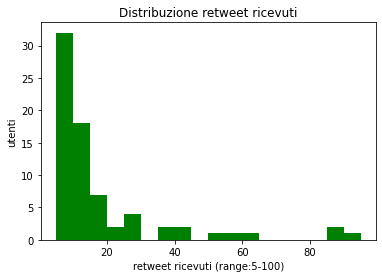

In [48]:
#distribuzione numero del numero dei retweet ricevuti in un range tra 5 e 100
def plot_in_degree_dist(G):
    bins=np.arange(5,100,5)  
    degrees = sorted([G.in_degree(n) for n in G.nodes()])
    plt.hist(degrees, bins, color='green')
    plt.ylabel('utenti')
    plt.xlabel('retweet ricevuti (range:5-100)')
    plt.title('Distribuzione retweet ricevuti')
    plt.show()

plot_in_degree_dist(G_directed)

In [56]:
pd.DataFrame(G_directed.in_degree(),columns=["nodo","grado"])

,nodo,grado
0,321228288,0
1,1173223843,18
2,1426639026824564737,0
3,1364298062919794688,888
4,272945830,0
...,...,...
3522,1314673923271856128,0
3523,613859050,0
3524,40653660,0
3525,195333276,0


In [62]:
#The in-degree centrality for a node v is the fraction of nodes its incoming edges are connected to
#top10 dei nodi con il maggior numero di archi entranti (i più retwettati)--> HUBS
in_degree_centrality=nx.in_degree_centrality(G_directed)
in_degree_centrality_sort=dict(sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_IN_C=list(in_degree_centrality_sort.items())[:10]
top10_IN_C

[(1364298062919794688, 0.25184344866704483),
 (22038676, 0.16420873511060693),
 (231902290, 0.12024957458876916),
 (1155459166380744709, 0.09188882586500284),
 (1087731393633939462, 0.06664775950085083),
 (872076729535406080, 0.058423142370958595),
 (1360232480, 0.053034600113443),
 (1238800491632607232, 0.04140669313669881),
 (4882542093, 0.031480431083380604),
 (1095412353427013633, 0.026091888825865005)]

In [63]:
#The out-degree centrality for a node v is the fraction of nodes its outcoming edges are connected to
#top10 dei nodi con il maggior numero di archi uscenti (chi ha retwittato di più)
out_degree_centrality=nx.out_degree_centrality(G_directed)
out_degree_centrality_sort=dict(sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_OUT_C=list(out_degree_centrality_sort.items())[:10]
top10_OUT_C

[(1223954414807011328, 0.003403289846851957),
 (1432941587324092418, 0.003119682359614294),
 (1036611673, 0.002836074872376631),
 (1036307375744016386, 0.002836074872376631),
 (1436400225292259360, 0.0025524673851389677),
 (4192961459, 0.0022688598979013048),
 (71593119, 0.0022688598979013048),
 (1042906497129361408, 0.0022688598979013048),
 (1420711554270511107, 0.0022688598979013048),
 (1227171998356443136, 0.0022688598979013048)]

In [66]:
#CLOSENESS CENTRALITY
# of a node is a measure of centrality in a network, 
# calculated as the reciprocal of the sum of the length of the shortest paths between the node 
# and all other nodes in the graph. Thus, the more central a node is, the closer it is to all 
# other nodes.
closeness_centrality=nx.closeness_centrality(G_directed)

In [68]:
#trovo i top5 utenti per closeness_centrality
closeness_centrality_sort=dict(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse= True))
top10_CC=pd.DataFrame(list(closeness_centrality_sort.items())[:5],columns=("id_utente","closeness centrality"))
top10_CC=pd.merge(top10_CC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top10_CC.drop("Id",axis=1,inplace=True)
top10_CC

,id_utente,closeness centrality,Label
0,1364298062919794688,0.253195,Lorenzo62752880
1,22038676,0.198659,mariannaaprile
2,231902290,0.121286,Cartabellotta
3,1155459166380744709,0.108495,ArmoniosiAccent
4,1087731393633939462,0.066649,Sfrida2


In [70]:
#BETWEENNESS CENTRALITY
#betweenness centrality is a measure of centrality in a graph based on shortest paths. 
#Centrality misura l’importanza di un nodo nelle «comunicazioni» con gli altri nodi e
#quindi l’ influenza all'interno di una rete in virtù del «controllo sulle informazioni» che passano,
#pertanto si riferisce a quanto un nodo sia di passaggio 
betweenness_centrality=nx.betweenness_centrality(G_nx)

In [71]:
#trovo i top5 utenti per betweenness_centrality
betweenness_centrality_sort=dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse= True))
top5_BC=pd.DataFrame(list(betweenness_centrality_sort.items())[:5],columns=("id_utente","betweenness centrality"))
top5_BC=pd.merge(top5_BC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_BC.drop("Id",axis=1,inplace=True)
top5_BC

,id_utente,betweenness centrality,Label
0,22038676,0.501206,mariannaaprile
1,1364298062919794688,0.461189,Lorenzo62752880
2,231902290,0.210094,Cartabellotta
3,1155459166380744709,0.140428,ArmoniosiAccent
4,872076729535406080,0.130191,laggiu17


##### Percolation?

In [47]:
from percolation import *

ModuleNotFoundError: No module named 'percolation'

In [ ]:
percolation_centrality